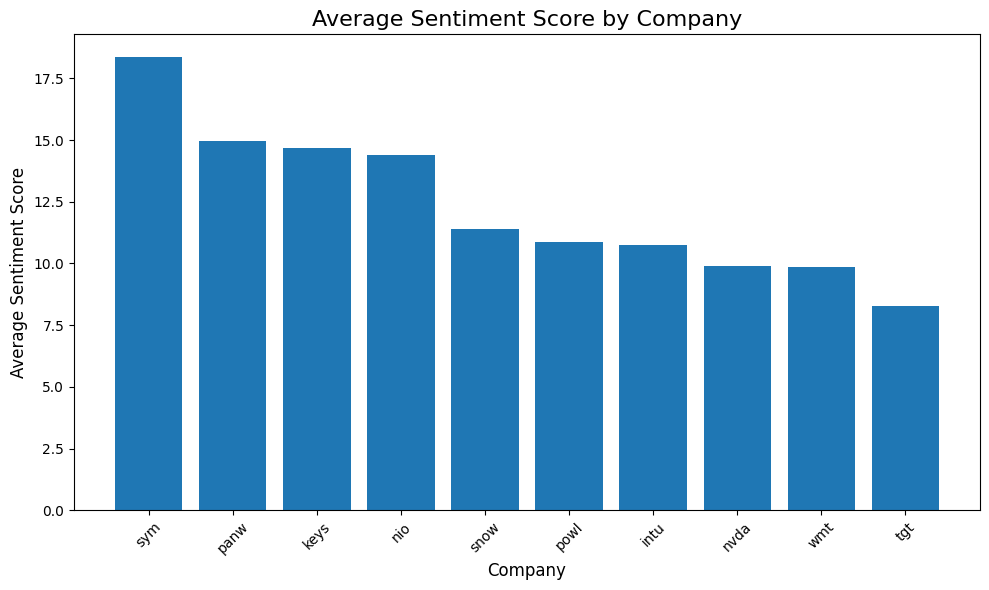

In [81]:
# Group data by company and calculate the average sentiment score for each company
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('data/combined_dataset.csv') 

company_sentiment = data.groupby('company')['score'].mean().reset_index()

# Sort by score for better visualization
company_sentiment = company_sentiment.sort_values(by='score', ascending=False)

# Plot sentiment by company as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(company_sentiment['company'], company_sentiment['score'])
plt.title('Average Sentiment Score by Company', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
